In [134]:
# Standard libraries
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error 

# Enable auto-reload for module reloading during development
%load_ext autoreload
%autoreload 2

# Set display options for Pandas to show all columns
pd.set_option('display.max_columns', None)

# Load custom scripts
import scp.data_check as ch
import scp.decision_tree as dt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load dataset
assets = pd.read_csv('dataset/king_country_houses_aa.csv')

In [3]:
# First look at the first few rows of the dataset
assets.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# Check data types, number of missing values, duplicates, and unique values
ch.check(assets)

Number of columns: 21 and rows: 21613

Data types:
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Unique values count:
id               21436
date               372
price             4028
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             

In [104]:
# Copy of the data
df = assets.copy()

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
dtype: float64

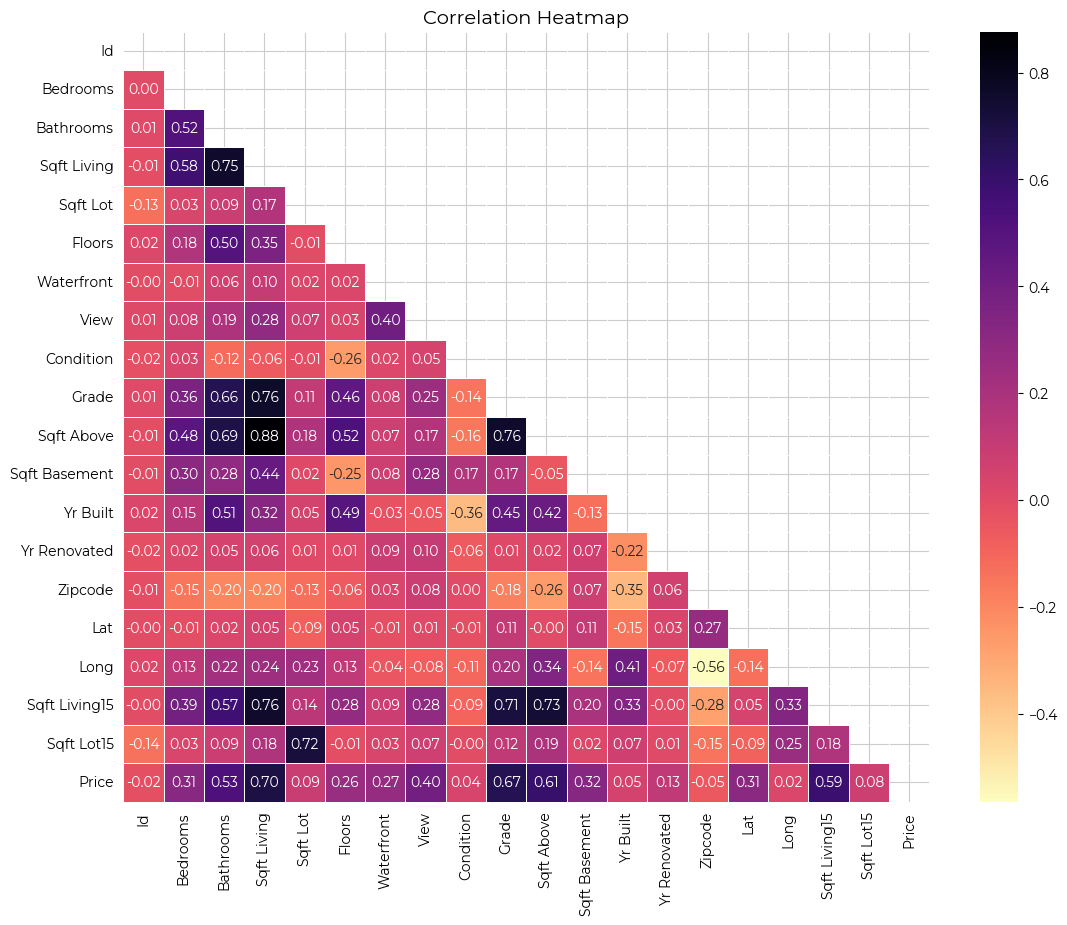

In [105]:
correlation_with_price = dt.corr_heatmap(df)
correlation_with_price

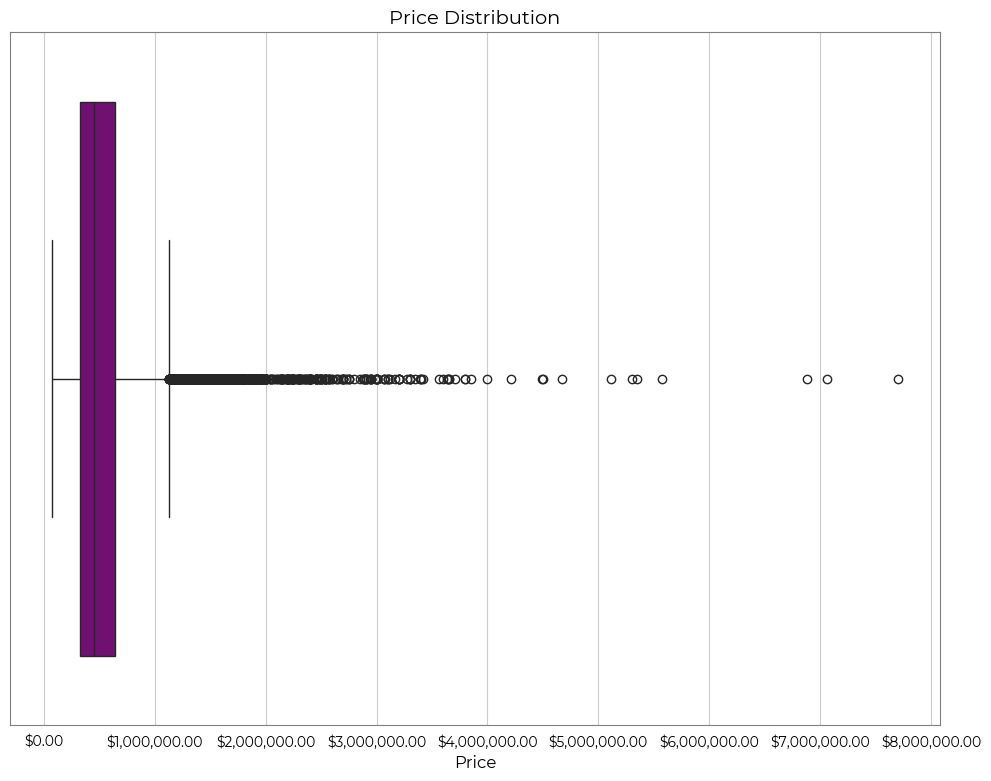

In [106]:
from matplotlib.ticker import FuncFormatter

def currency_formatter(x, pos):
    '''
    Custom formatter function to display y-axis values,
    formatted as currency with comma separators.

    Parameters:
    - x (float): The numerical value to format.
    - pos (int): The tick position (required for matplotlib formatters).

    Returns:
    - str: Formatted string representation of the value.
    '''
    return f'${x:,.2f}'

plt.figure(figsize=(12, 9))
sns.boxplot(x=df["price"], color="purple")
plt.title("Price Distribution", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.yticks([])
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_formatter))
plt.show()

In [107]:
# Remove outliers using IQR method
df_copy = df.copy()
Q1 = df_copy['price'].quantile(0.25)
Q3 = df_copy['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_without_outliers = df_copy[(df_copy['price'] >= lower_bound) & (df_copy['price'] <= upper_bound)]
ch.check(df_without_outliers)

Number of columns: 21 and rows: 20467

Data types:
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Unique values count:
id               20297
date               371
price             3543
bedrooms            13
bathrooms           26
sqft_living        899
sqft_lot          9274
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         840
sqft_basement      271
yr_built           116
yr_renovated        70
zipcode             

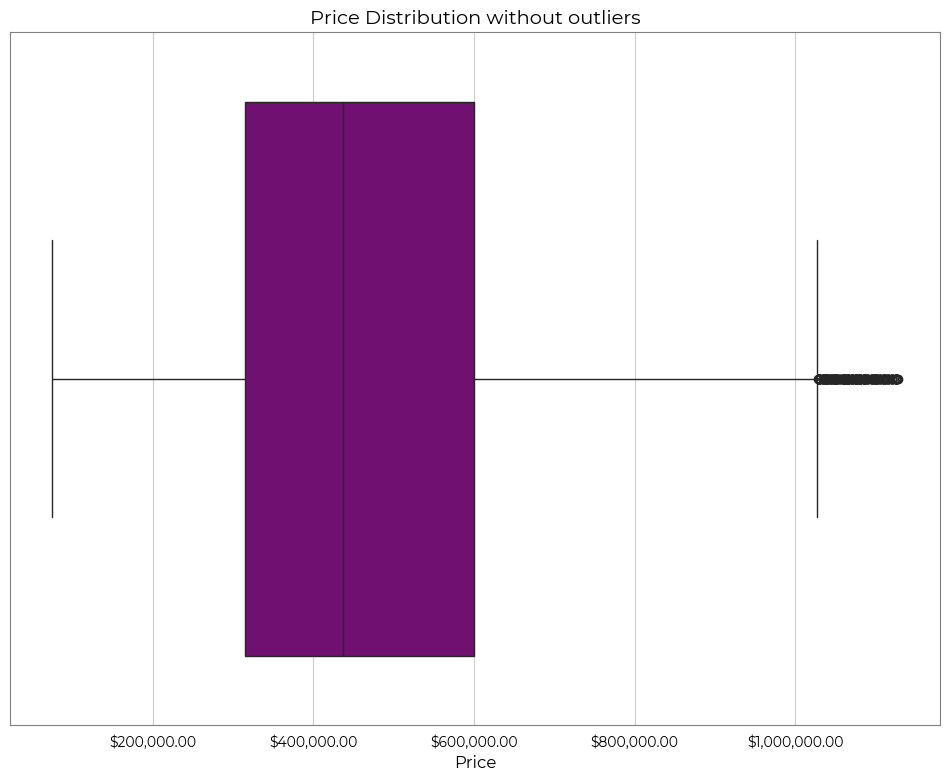

In [108]:
plt.figure(figsize=(12, 9))
sns.boxplot(x=df_without_outliers["price"], color="purple")
plt.title("Price Distribution without outliers", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.yticks([])
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_formatter))
plt.show()

## Decision Tree predictions using outliers

In [292]:
# Selecting feautures 
correlated_columns = dt.selecting_features(df, corr_coef=0.25)

Features with correlation coefficient with price > than 0.25
Columns that will be used for the training:
 ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement', 'bedrooms', 'lat', 'waterfront', 'floors'] 



In [293]:
X_train, X_test, y_train, y_test = dt.select_training_set(df, correlated_columns, test_size=0.4)

🔹 Test size 40%:
  Training set size: 12967 | Test set size: 8646


In [294]:
results_df, results_list = dt.train_decision_tree(X_train, X_test, y_train, y_test)
results_df.head()

  Model Metrics: | R2 = 0.6416 | RMSE = 231455.5397 | MAE = 125950.7574 | MSE = 53571666875.0802 |
⚠️ The model is moderately good, but there’s room for improvement.



,Actual Price,Predicted Price,Difference
735,365000.0,365000.0,0.0
2830,865000.0,1265000.0,-400000.0
4106,1038000.0,1078500.0,-40500.0
16218,1490000.0,1580000.0,-90000.0
19964,711000.0,695000.0,16000.0


In [295]:
# Testing different test sizes
results_list = dt.create_train_test_splits_and_evaluate(df, correlated_columns)

🔹 Test size 10%:
  Training set size: 19451 | Test set size: 2162
  Model Metrics: | R2 = 0.6027 | RMSE = 240581.5981 | MAE = 128586.4302 | MSE = 57879505325.7364 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 20%:
  Training set size: 17290 | Test set size: 4323
  Model Metrics: | R2 = 0.5951 | RMSE = 247422.8555 | MAE = 125903.423 | MSE = 61218069416.6158 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 30%:
  Training set size: 15129 | Test set size: 6484
  Model Metrics: | R2 = 0.6055 | RMSE = 238638.9771 | MAE = 126658.1947 | MSE = 56948561394.7899 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 40%:
  Training set size: 12967 | Test set size: 8646
  Model Metrics: | R2 = 0.6416 | RMSE = 231455.5397 | MAE = 125950.7574 | MSE = 53571666875.0802 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 50%:
  Training set size: 10806 | Test set size: 10807
  

In [296]:
# Evaluating different features
results_df = dt.evaluate_different_correlations(df)

Features with correlation coefficient with price > than 0.2
Columns that will be used for the training:
 ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement', 'bedrooms', 'lat', 'waterfront', 'floors'] 

🔹 Test size 10%:
  Training set size: 19451 | Test set size: 2162
  Model Metrics: | R2 = 0.6027 | RMSE = 240581.5981 | MAE = 128586.4302 | MSE = 57879505325.7364 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 20%:
  Training set size: 17290 | Test set size: 4323
  Model Metrics: | R2 = 0.5951 | RMSE = 247422.8555 | MAE = 125903.423 | MSE = 61218069416.6158 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 30%:
  Training set size: 15129 | Test set size: 6484
  Model Metrics: | R2 = 0.6055 | RMSE = 238638.9771 | MAE = 126658.1947 | MSE = 56948561394.7899 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 40%:
  Training set size: 12967 | Test set siz

In [297]:
# A resume of metrics for test_size and features
results_df.head(55)

,Correlation Coefficient ≥,Test Size (%),R²,RMSE,MAE,MSE
0,0.20,0.1,0.602692,240581.598061,128586.430157,5.787951e+10
1,0.20,0.2,0.595056,247422.855486,125903.423009,6.121807e+10
2,0.20,0.3,0.605528,238638.977107,126658.194736,5.694856e+10
3,0.20,0.4,0.641626,231455.539737,125950.757364,5.357167e+10
4,0.20,0.5,0.643189,230538.016145,124788.914685,5.314778e+10
5,0.25,0.1,0.602692,240581.598061,128586.430157,5.787951e+10
6,0.25,0.2,0.595056,247422.855486,125903.423009,6.121807e+10
7,0.25,0.3,0.605528,238638.977107,126658.194736,5.694856e+10
8,0.25,0.4,0.641626,231455.539737,125950.757364,5.357167e+10
9,0.25,0.5,0.643189,230538.016145,124788.914685,5.314778e+10


In [298]:
# Cross validation for coefficient with price > than 0.2
resuls, average = dt.cross_validate_model(df, correlated_columns)
resuls

Cross-Validation Results:
Number of folds: 5
Average Training R²:  0.9993
Average Test R²:  0.6408
⚠️ The model is moderately good, but there's room for improvement in its generalization.



,Fold,Train R²,Test R²
0,1,0.9992,0.5951
1,2,0.9994,0.6619
2,3,0.9994,0.6855
3,4,0.9993,0.6180
4,5,0.9993,0.6433


In [302]:
# Cross validation for coefficient with price > than 0.2 and different number of folds
results_by_n_splits = dt.tunning_cross_validate_model(df, correlated_columns)

Cross-Validation Results:
Number of folds: 5
Average Training R²:  0.9993
Average Test R²:  0.6408
⚠️ The model is moderately good, but there's room for improvement in its generalization.

Cross-Validation Results:
Number of folds: 7
Average Training R²:  0.9993
Average Test R²:  0.6301
⚠️ The model is moderately good, but there's room for improvement in its generalization.

Cross-Validation Results:
Number of folds: 10
Average Training R²:  0.9992
Average Test R²:  0.6307
⚠️ The model is moderately good, but there's room for improvement in its generalization.

Cross-Validation Results:
Number of folds: 13
Average Training R²:  0.9992
Average Test R²:  0.625
⚠️ The model is moderately good, but there's room for improvement in its generalization.

Cross-Validation Results:
Number of folds: 15
Average Training R²:  0.9992
Average Test R²:  0.633
⚠️ The model is moderately good, but there's room for improvement in its generalization.



In [303]:
results_by_n_splits.head(5)

,n_splits,Average Train R²,Average Test R²
0,5,0.9993,0.6408
1,7,0.9993,0.6301
2,10,0.9992,0.6307
3,13,0.9992,0.6250
4,15,0.9992,0.6330


## Decision Tree predictions without outliers

In [245]:
# Remove outliers using IQR method
df_copy = df.copy()
Q1 = df_copy['price'].quantile(0.25)
Q3 = df_copy['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_without_outliers = df_copy[(df_copy['price'] >= lower_bound) & (df_copy['price'] <= upper_bound)]

In [246]:
# Selecting feautures 
correlated_columns = dt.selecting_features(df_without_outliers, corr_coef=0.25)

Features with correlation coefficient with price > than 0.25
Columns that will be used for the training:
 ['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat', 'bedrooms', 'floors'] 



In [247]:
X_train, X_test, y_train, y_test = dt.select_training_set(df_without_outliers, correlated_columns, test_size=0.4)

🔹 Test size 40%:
  Training set size: 12280 | Test set size: 8187


In [248]:
results_df, results_list = dt.train_decision_tree(X_train, X_test, y_train, y_test)
results_df.head()

  Model Metrics: | R2 = 0.5966 | RMSE = 130791.1207 | MAE = 91968.9347 | MSE = 17106317243.2701 |
⚠️ The model is moderately good, but there’s room for improvement.



,Actual Price,Predicted Price,Difference
16607,420000.0,585000.0,-165000.0
15557,230000.0,255000.0,-25000.0
1285,270000.0,299000.0,-29000.0
5964,807000.0,850000.0,-43000.0
7051,225000.0,260250.0,-35250.0


In [249]:
# Testing different test sizes
results_list = dt.create_train_test_splits_and_evaluate(df_without_outliers, correlated_columns)

🔹 Test size 10%:
  Training set size: 18420 | Test set size: 2047
  Model Metrics: | R2 = 0.6144 | RMSE = 126463.1813 | MAE = 87487.1864 | MSE = 15992936212.3357 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 20%:
  Training set size: 16373 | Test set size: 4094
  Model Metrics: | R2 = 0.5953 | RMSE = 129816.243 | MAE = 91705.4618 | MSE = 16852256949.9485 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 30%:
  Training set size: 14326 | Test set size: 6141
  Model Metrics: | R2 = 0.5792 | RMSE = 133172.1704 | MAE = 93548.1541 | MSE = 17734826965.3169 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 40%:
  Training set size: 12280 | Test set size: 8187
  Model Metrics: | R2 = 0.5966 | RMSE = 130791.1207 | MAE = 91968.9347 | MSE = 17106317243.2701 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 50%:
  Training set size: 10233 | Test set size: 10234
  Mode

In [236]:
# Evaluating different features
results_df = dt.evaluate_different_correlations(df_without_outliers)

Features with correlation coefficient with price > than 0.2
Columns that will be used for the training:
 ['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat', 'bedrooms', 'floors', 'view', 'sqft_basement'] 

🔹 Test size 10%:
  Training set size: 18420 | Test set size: 2047
  Model Metrics: | R2 = 0.6273 | RMSE = 124323.2097 | MAE = 87426.1128 | MSE = 15456260463.6878 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 20%:
  Training set size: 16373 | Test set size: 4094
  Model Metrics: | R2 = 0.6025 | RMSE = 128666.5716 | MAE = 90087.1931 | MSE = 16555086639.9767 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 30%:
  Training set size: 14326 | Test set size: 6141
  Model Metrics: | R2 = 0.6092 | RMSE = 128327.0836 | MAE = 90772.7315 | MSE = 16467840395.7227 |
⚠️ The model is moderately good, but there’s room for improvement.

🔹 Test size 40%:
  Training set size: 12280 | Test set size: 8187
  Model 

In [237]:
# A resume of metrics for test_size and features
results_df.head(55)

,Correlation Coefficient ≥,Test Size (%),R²,RMSE,MAE,MSE
0,0.20,0.1,0.627340,124323.209674,87426.112848,1.545626e+10
1,0.20,0.2,0.602462,128666.571572,90087.193087,1.655509e+10
2,0.20,0.3,0.609222,128327.083641,90772.731531,1.646784e+10
3,0.20,0.4,0.611285,128384.191799,90183.862587,1.648250e+10
4,0.20,0.5,0.619973,127537.251424,90109.067960,1.626575e+10
5,0.25,0.1,0.614401,126463.181252,87487.186370,1.599294e+10
6,0.25,0.2,0.595326,129816.243013,91705.461814,1.685226e+10
7,0.25,0.3,0.579157,133172.170386,93548.154128,1.773483e+10
8,0.25,0.4,0.596573,130791.120659,91968.934652,1.710632e+10
9,0.25,0.5,0.591188,132279.282184,92918.221175,1.749781e+10


In [ ]:
# Cross validation
resuls = dt.cross_validate_model(df_without_outliers, correlated_columns, n_splits=5)
resuls

Cross-Validation Results:
Average Training R²:  0.9978
Average Test R²:  0.5944
⚠️ The model is moderately good, but there's room for improvement in its generalization.


,Fold,Train R²,Test R²
0,1,0.9978,0.5953
1,2,0.9982,0.5731
2,3,0.9977,0.5993
3,4,0.9974,0.5852
4,5,0.9976,0.6188
